# **Student Details**
**Name:** Kieron Drumm</br>
**Student Number:** 13314446</br>
**Module Code:** CA683</br>
**Module Name:** Data Analytics & Data Mining</br>
**Lecturer:** Dr. Andrew McCarren</br>

# **Plagiarism Policy**
I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. I have read and understood the Assignment Regulations. I have identified and included the source of all facts, ideas, opinions, and viewpoints of others in the assignment references. Direct quotations from books, journal articles, internet sources, module text, or any other source whatsoever are acknowledged and the source cited are identified in the assignment references. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study.</br>

I have read and understood the referencing guidelines found at
http://www.dcu.ie/info/regulations/plagiarism.shtml,
https://www4.dcu.ie/students/az/plagiarism and/or recommended in the assignment
guidelines.

# **Initial Load**

Authenticate with Google Drive and read in our dataset.

In [ ]:
# Install any required packages.
!pip install -U -q imbalanced-learn # https://github.com/scikit-learn-contrib/imbalanced-learn
!pip install -U -q PyDrive          # https://github.com/googlearchive/PyDrive
!pip install -U -q shap             # https://github.com/slundberg/shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 5.9 MB/s eta 0:00:00


In [ ]:
# Import any required libraries.
from datetime import datetime
from google.colab import auth
from google.colab import drive
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from itertools import combinations
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
from scipy.stats import chi2_contingency, pearsonr, spearmanr
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
import pandas as pd
import shap

In [ ]:
# Authenticate with Google Drive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Download our dataset from Google Drive.
downloaded_file = drive.CreateFile({ 'id': '14RMV7CRXwwCt_9iLHenyQrB9GC5gYwul' })
downloaded_file.GetContentFile('ChicagoCrimeRecords.csv')
chicago_crime_records = pd.read_csv('ChicagoCrimeRecords.csv')

In [ ]:
# Clear the downloaded file and any other related variables from memory, once we've converted it to a data frame.
del downloaded_file, drive, gauth

# **Data Transformation/Feature Engineering**
Drop any unnecessary or redundant columns, impute or drop any missing values, encode any categorical features, and synthesis additional examples to offset the imbalance in our dataset.

In [ ]:
# Drop any NaNs.
chicago_crime_records.dropna(inplace = True)

In [ ]:
# Randomly sample our dataset, so that it is small enough to work with.
chicago_crime_records = chicago_crime_records.sample(125000, random_state = 785)

In [ ]:
# Drop any classes with less than 5 instances, as SMOTE will be unable to work with them (as it uses 3 k-neighbours).
is_multi = chicago_crime_records["Primary Type"].value_counts() > 5
chicago_crime_records = chicago_crime_records[chicago_crime_records["Primary Type"].isin(is_multi[is_multi].index)]

In [ ]:
# Create a new feature for the weekday, month, and hour on in, or on which the crime occurred.
chicago_crime_records["Weekday"] = chicago_crime_records.Date.map(lambda x: datetime(month = int(x[:2]),day = int(x[3:5]), year = int(x[6:10])).weekday())
chicago_crime_records["Month"] = chicago_crime_records.Date.map(lambda x: int(x[:2]))
chicago_crime_records["Hour"] = chicago_crime_records.Date.map(lambda x: int(x[11:13]) if x[-2:] == "AM" else int(x[11:13]) + 12)

In [ ]:
# Remove any features that we are confident will not be of any use to our model.
chicago_crime_records.drop(
    columns = [
        'Arrest',        # Occurs after the crime has been classified.
        'Case Number',   # Assigned after the crime has occurred.
        'Date',          # Replaced by 'Weekday', 'Month' and 'Hour'.
        'Description',   # A more granular version of 'Primary Type'.
        'FBI Code',      # An encoded form of 'Primary Type'.
        'Location',      # Replaced by 'Latitude', 'Longitude', 'X Coordinate', 'Y Coordinate'.
        'ID',            # Provides zero insight into the crime as it is simply an index for each row.
        'IUCR',          # An encoded form of 'Primary Type'.
        'Updated On'],   # Updated after the crime has already been recorded.
    axis = 1,
    inplace = True,
    errors = 'ignore')

In [ ]:
# Encode the 'Block', 'Domestic' and 'Location Description' features.
chicago_crime_records['Block'] = chicago_crime_records['Block'].astype('category')
chicago_crime_records['Block'] = chicago_crime_records['Block'].cat.codes

chicago_crime_records['Domestic'] = chicago_crime_records['Domestic'].astype(int)

chicago_crime_records['Location Description'] = chicago_crime_records['Location Description'].astype('category')
chicago_crime_records['Location Description'] = chicago_crime_records['Location Description'].cat.codes

In [ ]:
# Create a new feature, denoting whether or not a specific crime occurred.
crime_to_predict = 'Theft'
chicago_crime_records[crime_to_predict] = 0
chicago_crime_records.loc[chicago_crime_records['Primary Type'] == crime_to_predict.upper(), crime_to_predict] = 1

In [ ]:
# Test for multicollinearity between our nominal categorical features using a chi² test of independence.
nominal_features = [
    'Beat',
    'Block',
    'Community Area',
    'District',
    'Domestic',
    'Location Description']

for pair in list(combinations(nominal_features, 2)):
  test_result = chi2_contingency(pd.crosstab(chicago_crime_records[pair[0]], chicago_crime_records[pair[1]]))
  print(f"{pair[0]} + {pair[1]}: {'(Correlated)' if test_result.pvalue < 0.05 else '(Independent)'}")
  print(f"P-Value: {test_result.pvalue}\n")

Beat + Block: (Correlated)
P-Value: 0.0

Beat + Community Area: (Correlated)
P-Value: 0.0

Beat + District: (Correlated)
P-Value: 0.0

Beat + Domestic: (Correlated)
P-Value: 0.0

Beat + Location Description: (Correlated)
P-Value: 0.0

Block + Community Area: (Correlated)
P-Value: 0.0

Block + District: (Correlated)
P-Value: 0.0

Block + Domestic: (Correlated)
P-Value: 4.3828009272968904e-169

Block + Location Description: (Correlated)
P-Value: 0.0

Community Area + District: (Correlated)
P-Value: 0.0

Community Area + Domestic: (Correlated)
P-Value: 0.0

Community Area + Location Description: (Correlated)
P-Value: 0.0

District + Domestic: (Correlated)
P-Value: 0.0

District + Location Description: (Correlated)
P-Value: 0.0

Domestic + Location Description: (Correlated)
P-Value: 0.0



In [ ]:
# Test for multicollinearity between our ordinal categorical features using the Spearman rank correlation coefficient.
ordinal_features = [
    'Hour',
    'Month',
    'Weekday',
    'Year']

for pair in list(combinations(ordinal_features, 2)):
  spearman_coefficient, p_value = spearmanr(chicago_crime_records[pair[0]], chicago_crime_records[pair[1]])
  print(f"{pair[0]} + {pair[1]}: {'(Correlated)' if p_value < 0.05 else '(Independent)'}")
  print(f"Spearman Coefficient: {spearman_coefficient}\n")
  print(f"P-Value: {p_value}\n")

Hour + Month: (Independent)
Spearman Coefficient: 0.003113688271989391

P-Value: 0.27098063257124677

Hour + Weekday: (Correlated)
Spearman Coefficient: -0.027150655872373215

P-Value: 7.953089523996094e-22

Hour + Year: (Correlated)
Spearman Coefficient: -0.023878278215956457

P-Value: 3.09132157359237e-17

Month + Weekday: (Correlated)
Spearman Coefficient: 0.007114482476837684

P-Value: 0.011894276683866237

Month + Year: (Correlated)
Spearman Coefficient: -0.037829850525178677

P-Value: 8.017045313509494e-41

Weekday + Year: (Independent)
Spearman Coefficient: 0.002838856926927631

P-Value: 0.31555055489558864



In [ ]:
# Test for multicollinearity between our numerical features using the Pearson correlation coefficient.
numerical_features = [
    'Latitude',
    'Longitude',
    'X Coordinate',
    'Y Coordinate']

for pair in list(combinations(numerical_features, 2)):
  pearson_coefficient, _ = pearsonr(chicago_crime_records[pair[0]], chicago_crime_records[pair[1]])
  print(f"{pair[0]} + {pair[1]}:")
  print(f"Pearson Coefficient: {pearson_coefficient}\n")
  #print(f"Pearson Coefficient: {pearson_coefficient.}\n")


Latitude + Longitude:
Pearson Coefficient: -0.5515253240676137

Latitude + X Coordinate:
Pearson Coefficient: -0.5620154222435166

Latitude + Y Coordinate:
Pearson Coefficient: 0.999994724945698

Longitude + X Coordinate:
Pearson Coefficient: 0.9999194876256534

Longitude + Y Coordinate:
Pearson Coefficient: -0.548821309775595

X Coordinate + Y Coordinate:
Pearson Coefficient: -0.5593338710438345



In [ ]:
# Remove some of our numerical features, in accordance with the results of the pearson correlation test above.
chicago_crime_records.drop(
    columns = [
        'Latitude',     # Is highly correlated with 'Y Coordinate'.
        'Longitude'],   # Is highly correlated with 'X Coordinate'.
    axis = 1,
    inplace = True,
    errors = 'ignore')

In [ ]:
# Separate out our Xs and Y.
X = chicago_crime_records.drop(columns = ['Primary Type', crime_to_predict])
Y = chicago_crime_records[crime_to_predict]

In [ ]:
# Reset the indexes for our data frames.
X.reset_index(drop = True, inplace = True)
Y.reset_index(drop = True, inplace = True)

In [ ]:
# Synthesise new examples using SMOTE and undersampling.
oversampler = SMOTE(k_neighbors = 3)
undersampler = RandomUnderSampler()
pipeline = Pipeline(steps= [('o', oversampler), ('u', undersampler)])
X, Y = pipeline.fit_resample(X, Y)

In [ ]:
# Inspect 'X' before we split it out into training and test data.
X.head()

,Block,Location Description,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Weekday,Month,Hour
0,18102,114,0,812,8.0,13.0,64.0,1137269.0,1861143.0,2006,0,7,16
1,4761,133,0,1011,10.0,24.0,29.0,1149264.0,1893506.0,2019,2,11,10
2,19848,114,0,831,8.0,18.0,66.0,1159924.0,1857830.0,2007,3,4,11
3,16340,114,1,932,9.0,16.0,61.0,1164923.0,1869278.0,2007,5,3,12
4,19739,114,0,2511,25.0,36.0,18.0,1129305.0,1918496.0,2016,3,6,23


In [ ]:
# Split out our data into training and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

In [ ]:
# Clear our unsplit data frames from memory.
del X, Y

# **Model Tuning**
Carry out some parametric tuning before we train our Random Forest classifier.

In [ ]:
# Carry out some hyperparameter tuning.
parameters = {
    'n_estimators': [25, 50, 75],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7, 9],
    'criterion': ['gini', 'entropy']
}

tuned_model = GridSearchCV(RandomForestClassifier(), parameters).fit(X_train, Y_train)

In [ ]:
# Take a look at the resultant parameters.
tuned_model.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'log2',
 'n_estimators': 50}

# **Model Training**
Train a Random Forest classifier.

In [ ]:
# Train a Random Forest classifier.
classifier = RandomForestClassifier(
    bootstrap = True,
    class_weight = None,
    criterion = 'gini',
    max_depth = 9,
    max_features = 'log2',
    max_leaf_nodes = None,
    min_impurity_decrease = 0.0,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_weight_fraction_leaf = 0.0,
    n_estimators = 50,
    n_jobs = 1,
    oob_score = True,
    random_state = 411,
    verbose = 0,
    warm_start = False)

classifier.fit(X_train, Y_train)
classifier_predictions = classifier.predict(X_test)

# **Model Evalution**
Evaluate our Random Forest classifier.

In [ ]:
# Evaluate the accuracy, recall, precision, F1-score, and AUC-ROC of our model.
print("Accuracy: ", accuracy_score(Y_test, classifier_predictions))
print("Recall", recall_score(Y_test, classifier_predictions, average = 'macro'))
print("Precision", precision_score(Y_test, classifier_predictions, average = 'macro'))
print("F1 Score", f1_score(Y_test, classifier_predictions, average = 'macro'))
print("ROC-AUC", roc_auc_score(Y_test, classifier_predictions, average = 'macro'))

Accuracy:  0.7437547504433747
Recall 0.7439055586709227
Precision 0.7467213045692745
F1 Score 0.743058925228874
ROC-AUC 0.7439055586709227


In [ ]:
# Calculate the Shapley additive explanations for our model.
shap_values = shap.TreeExplainer(classifier).shap_values(X_train)

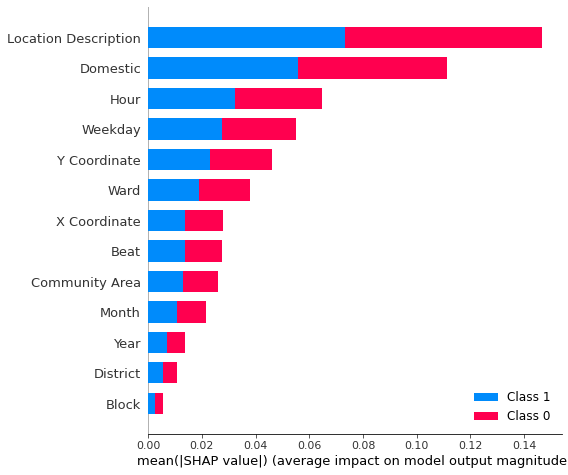

In [ ]:
# Display the Shapley additive explanations for our model.
shap.summary_plot(shap_values, features = X_train, feature_names = X_train.columns)